In [ ]:
import os
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch

# Paths
news_path = '../data/raw_analyst_rating_cleaned.csv'
stocks_folder = '../data/yfinance_data'

# -----------------------
# 1. Load and Clean News
# -----------------------
news_df = pd.read_csv(news_path, parse_dates=['date'])

# Basic cleaning
news_df['headline'] = news_df['headline'].astype(str)
news_df['date'] = pd.to_datetime(news_df['date']).dt.date


In [2]:
# Sentiment Analysis using Textblob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

news_df['sentiment'] = news_df['headline'].apply(get_sentiment)
# Daily Average Sentiment
daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()
daily_sentiment.columns = ['Date', 'Avg_Sentiment']

In [3]:
daily_sentiment.to_csv('../data/daily_sentiment.csv', index=False)

In [4]:
#sentiment analysis using VADER

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']  # Range: -1 to 1

news_df['sentiment_vader'] = news_df['headline'].apply(get_vader_sentiment)

# Daily Average Sentiment
daily_sentiment_vader = news_df.groupby('date')['sentiment_vader'].mean().reset_index()
daily_sentiment_vader.columns = ['Date', 'Avg_Sentiment_VADER']

In [5]:
daily_sentiment_vader.to_csv('../data/daily_sentiment_vader.csv', index=False)

In [ ]:
# -----------------------
# 2. Process Stock Data
# ------------------------
stock_returns = {}

for file in os.listdir(stocks_folder):
    if file.endswith('.csv'):
        stock_name = file.replace('.csv', '')
        df = pd.read_csv(os.path.join(stocks_folder, file), parse_dates=['Date'])
        df['Date'] = pd.to_datetime(df['Date']).dt.date
        df.sort_values('Date', inplace=True)
        df['Daily_Return'] = df['Close'].pct_change()
        df = df[['Date', 'Daily_Return']].dropna()
        

In [ ]:
# Merge all sentiment versions for comparison
merged_vader = pd.merge(df, daily_sentiment_vader, on='Date', how='inner')
merged_textblob = pd.merge(df, daily_sentiment, on='Date', how='inner')


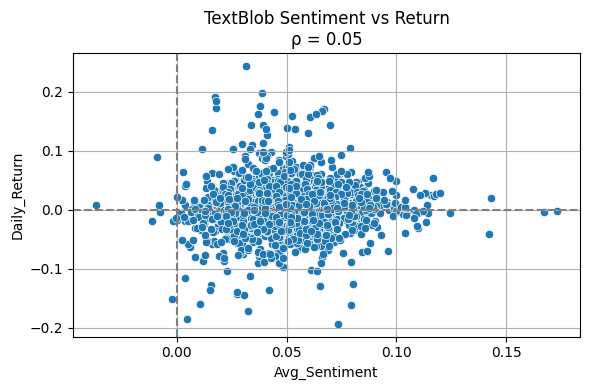

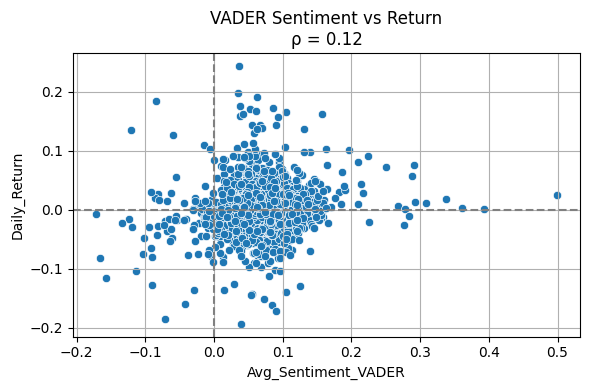

In [19]:
def plot_sentiment_vs_return(df, sentiment_col, title):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=sentiment_col, y='Daily_Return')
    correlation = df[sentiment_col].corr(df['Daily_Return'])
    plt.title(f'{title}\nρ = {correlation:.2f}')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_sentiment_vs_return(merged_textblob, 'Avg_Sentiment', "TextBlob Sentiment vs Return")
plot_sentiment_vs_return(merged_vader, 'Avg_Sentiment_VADER', "VADER Sentiment vs Return")
# plot_sentiment_vs_return(merged_finbert, 'Avg_Sentiment_FINBERT', "FinBERT Sentiment vs Return")

📊 AAPL_historical_data: Correlation = 0.1479
📊 AMZN_historical_data: Correlation = 0.0827
📊 GOOG_historical_data: Correlation = 0.1278
📊 META_historical_data: Correlation = 0.1637
📊 MSFT_historical_data: Correlation = 0.1233
📊 NVDA_historical_data: Correlation = 0.1165
📊 TSLA_historical_data: Correlation = 0.1183


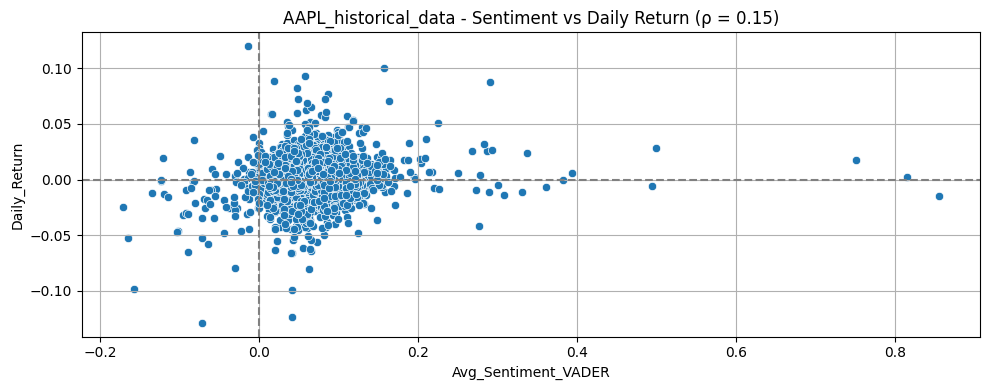

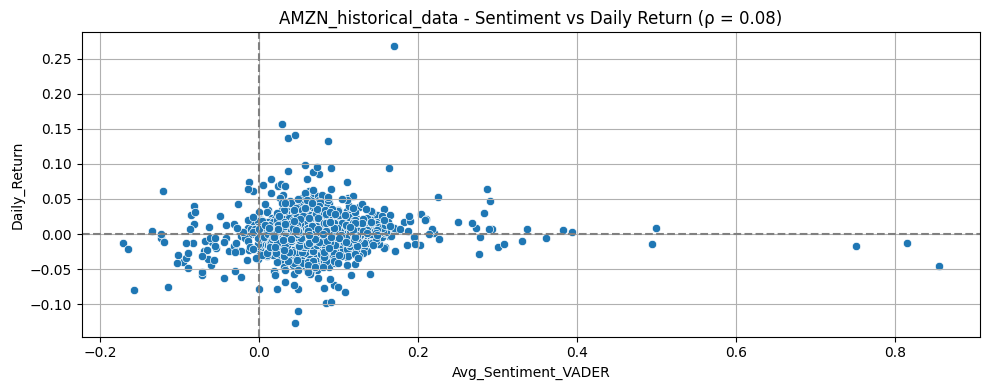

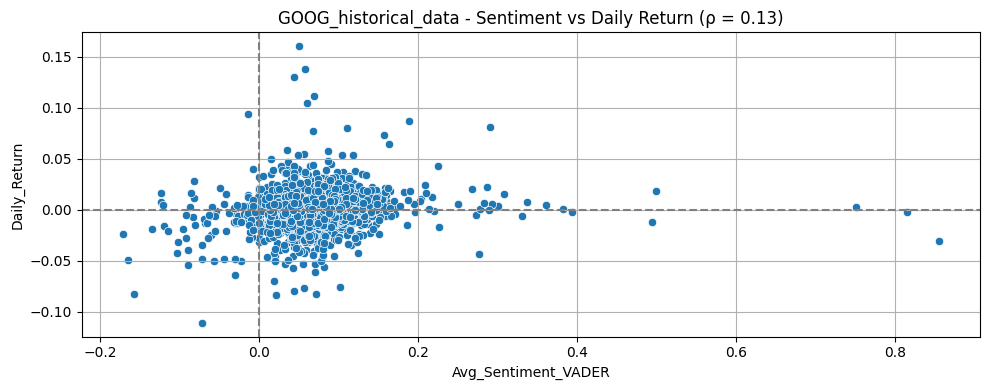

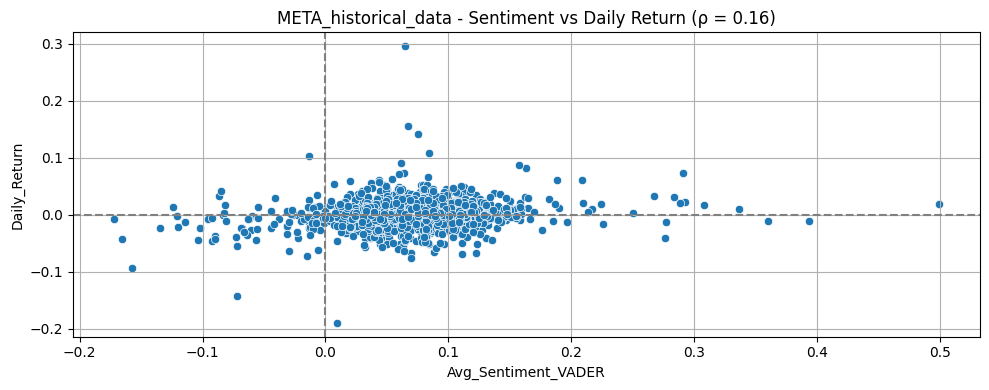

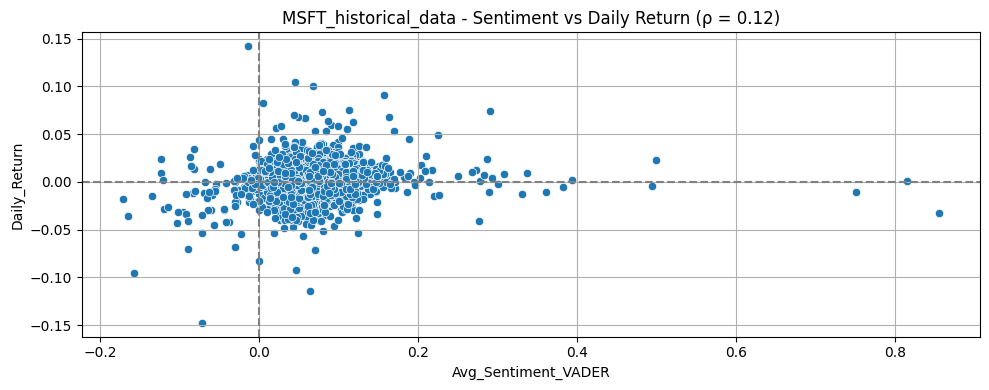

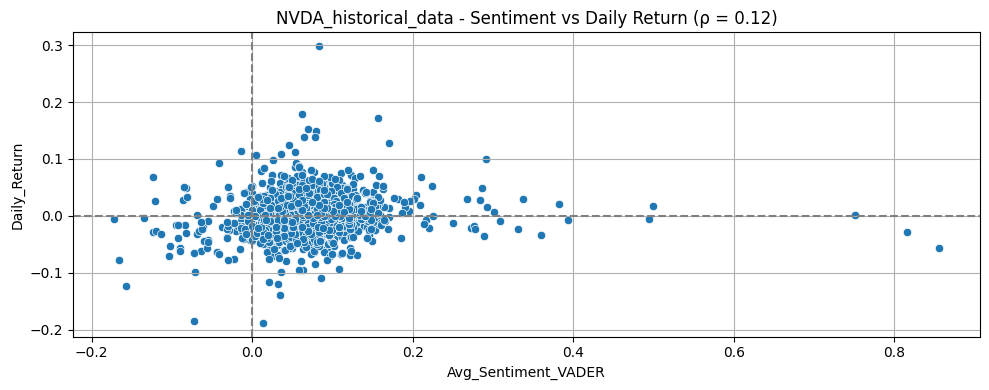

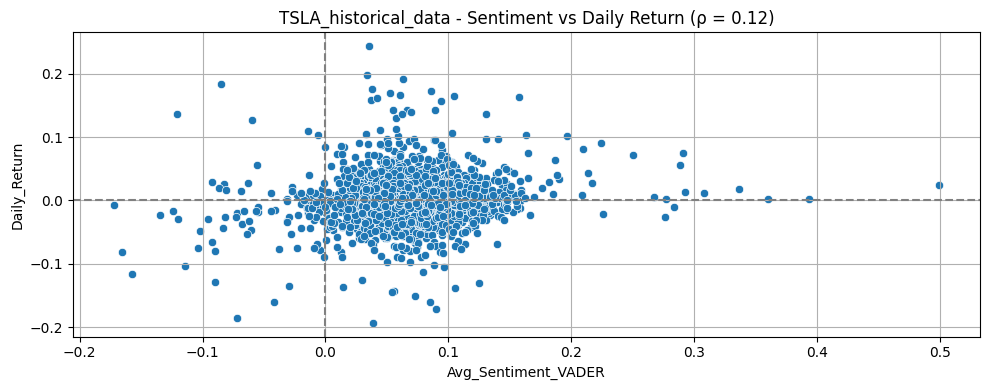

In [ ]:
# VISUALISATION FOR VADER SENTIMENT ANALYSIS

stock_returns = {}

for file in os.listdir(stocks_folder):
    if file.endswith('.csv'):
        stock_name = file.replace('.csv', '')
        df = pd.read_csv(os.path.join(stocks_folder, file), parse_dates=['Date'])
        df['Date'] = pd.to_datetime(df['Date']).dt.date
        df.sort_values('Date', inplace=True)
        df['Daily_Return'] = df['Close'].pct_change()
        df = df[['Date', 'Daily_Return']].dropna()
        
        # Merge with sentiment
        merged = pd.merge(df, daily_sentiment_vader, on='Date')
        
        # Correlation
        corr = merged['Daily_Return'].corr(merged['Avg_Sentiment_VADER'])
        stock_returns[stock_name] = {
            'Data': merged,
            'Correlation': corr
        }
        print(f"📊 {stock_name}: Correlation = {corr:.4f}")

# ------------------------
# 3. Visualization
# ------------------------
for stock, result in stock_returns.items():
    merged = result['Data']
    plt.figure(figsize=(10, 4))
    sns.scatterplot(data=merged, x='Avg_Sentiment_VADER', y='Daily_Return')
    plt.title(f'{stock} - Sentiment vs Daily Return (ρ = {result["Correlation"]:.2f})')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_1436\1219910455.py:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("sentiment_vs_return_all_stocks.png", bbox_inches='tight')
c:\Users\user\Desktop\Predicting-Price-Moves-with-News-Sentiment\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


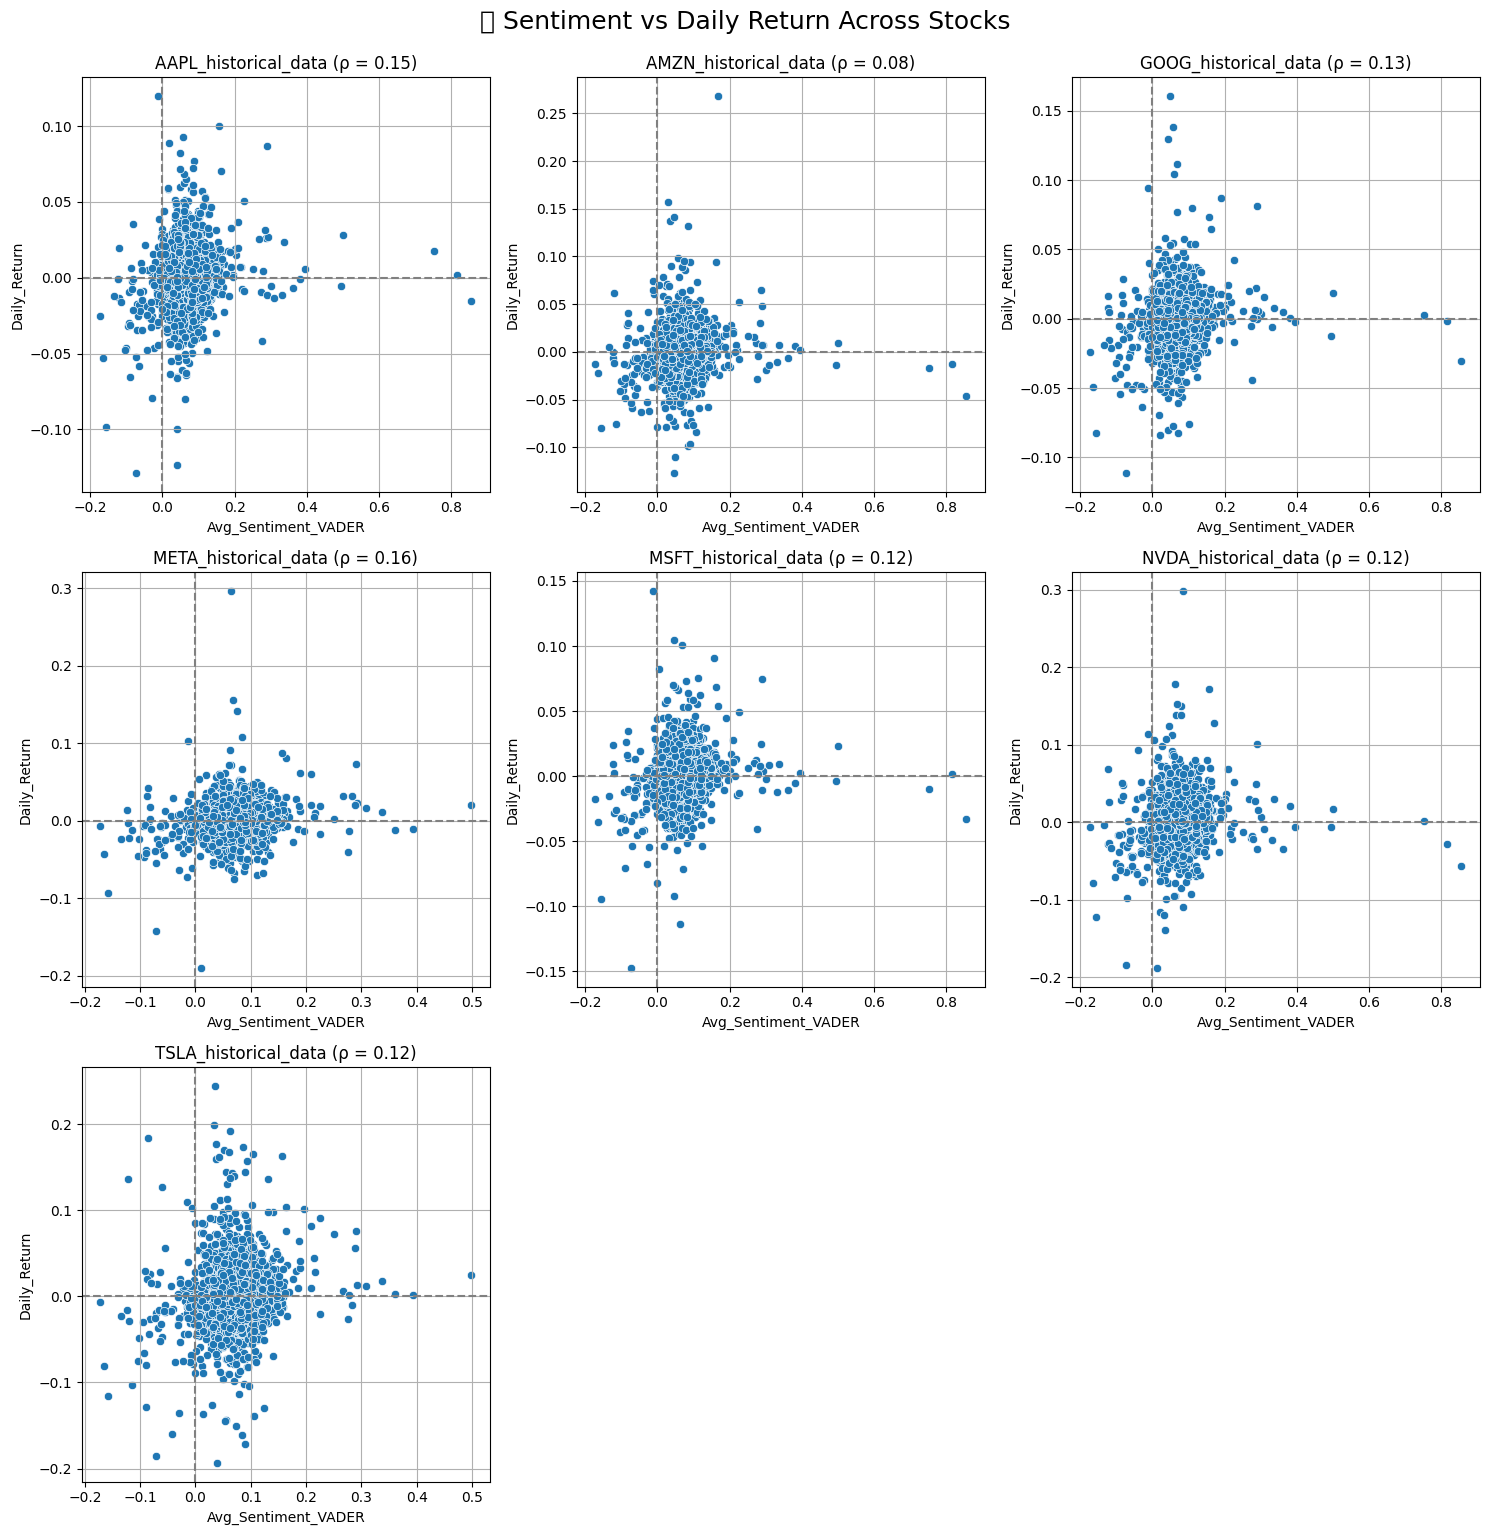

In [24]:
num_stocks = len(stock_returns)
cols = 3  # 3 columns for layout
rows = (num_stocks + cols - 1) // cols  # auto-calculate number of rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, (stock, result) in enumerate(stock_returns.items()):
    merged = result['Data']
    ax = axes[i]
    
    sns.scatterplot(data=merged, x='Avg_Sentiment_VADER', y='Daily_Return', ax=ax)
    ax.set_title(f'{stock} (ρ = {result["Correlation"]:.2f})')
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.grid(True)

# Turn off unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("📈 Sentiment vs Daily Return Across Stocks", fontsize=18, y=1.02)
plt.savefig("sentiment_vs_return_all_stocks.png", bbox_inches='tight')
plt.show()

📊 AAPL_historical_data: Correlation = 0.0455
📊 AMZN_historical_data: Correlation = 0.0058
📊 GOOG_historical_data: Correlation = 0.0173
📊 META_historical_data: Correlation = 0.0877
📊 MSFT_historical_data: Correlation = 0.0328
📊 NVDA_historical_data: Correlation = -0.0264
📊 TSLA_historical_data: Correlation = 0.0498


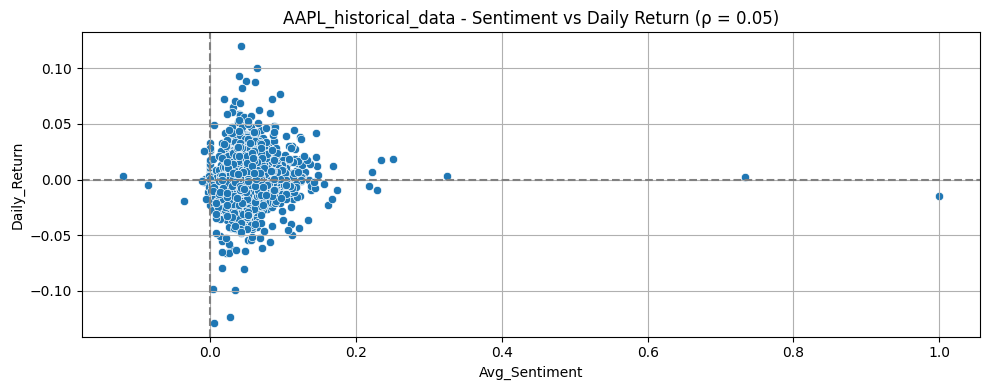

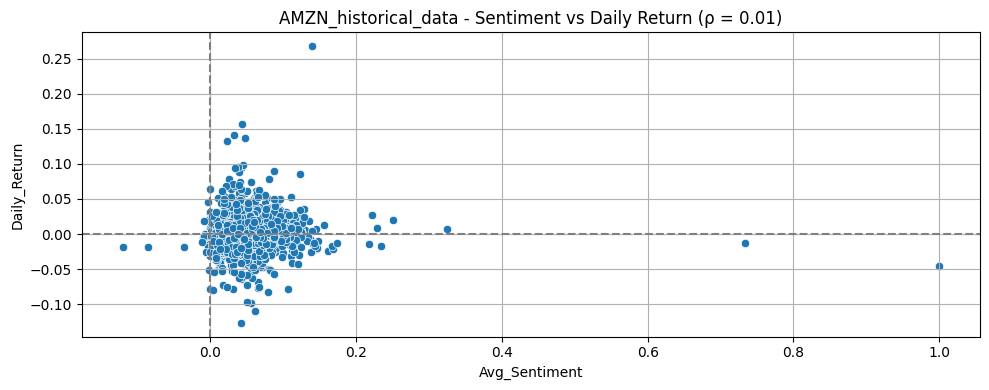

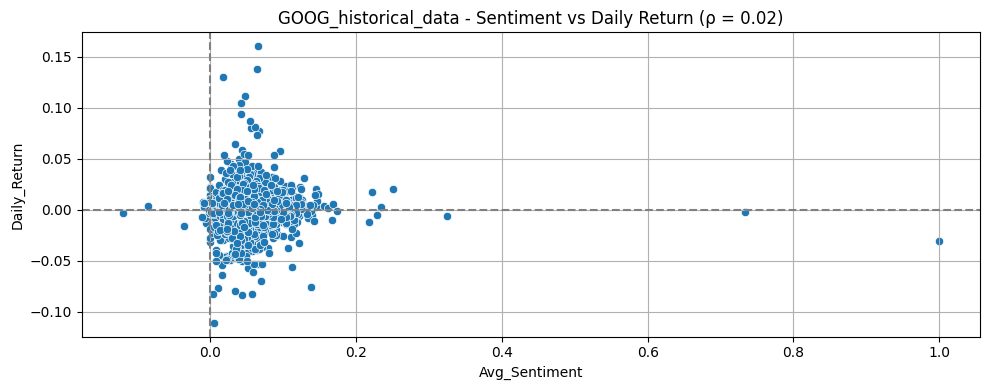

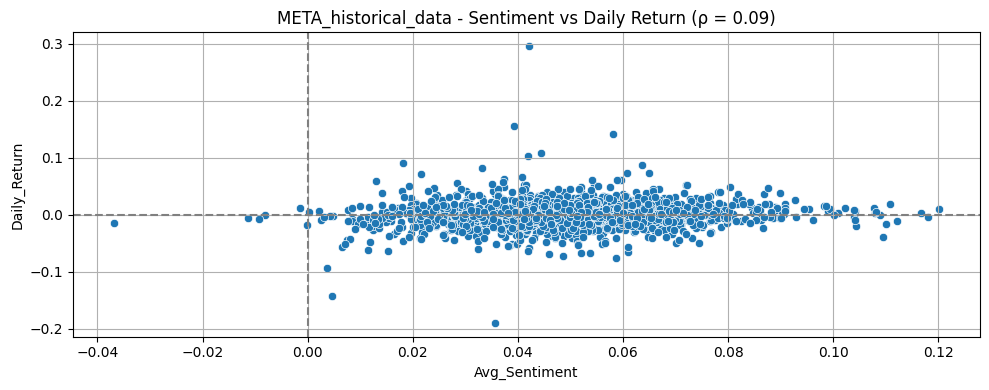

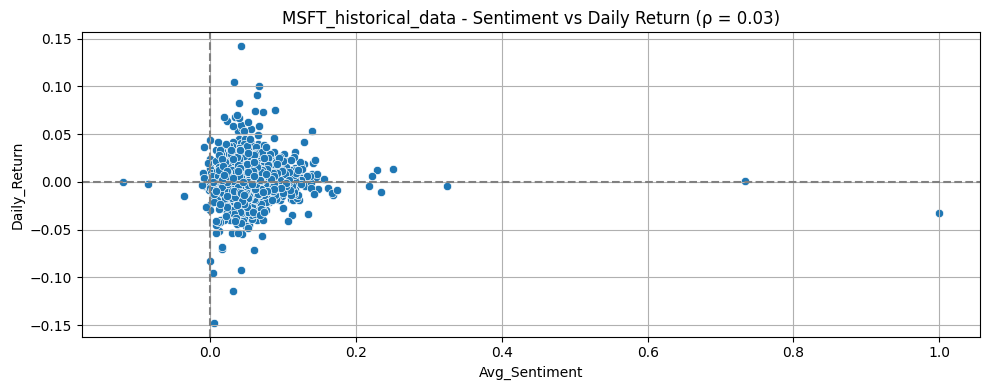

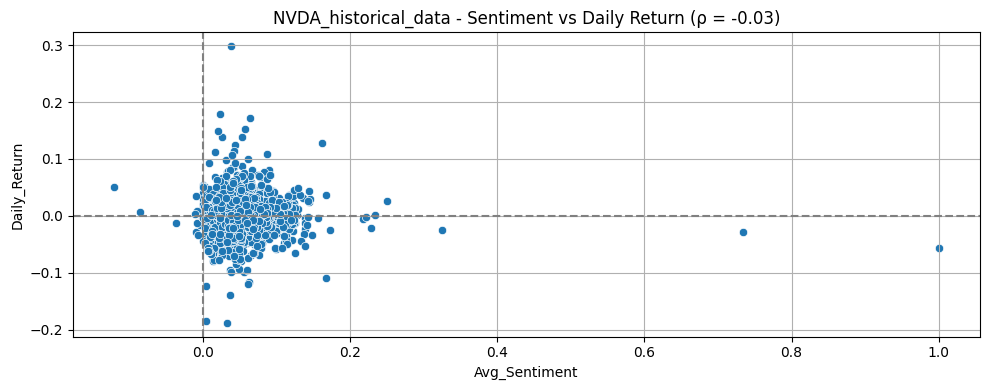

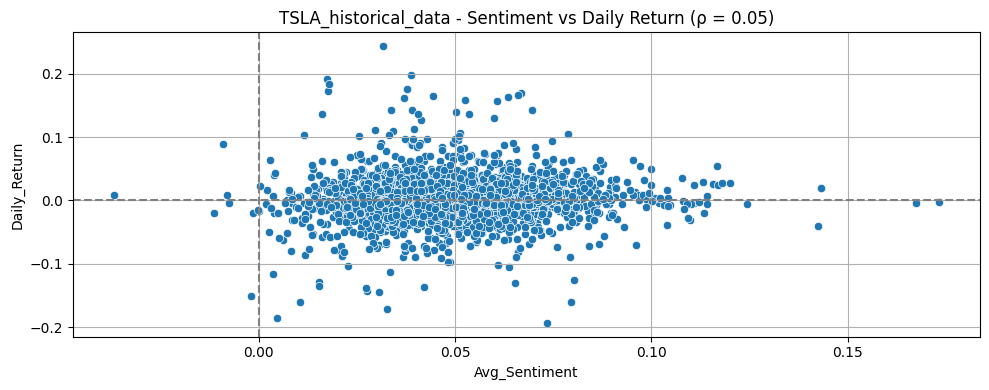

In [ ]:
#VISUALIZATION USING TEXTBLOB SENTIMENT ANALYSIS
stock_returns = {}

for file in os.listdir(stocks_folder):
    if file.endswith('.csv'):
        stock_name = file.replace('.csv', '')
        df = pd.read_csv(os.path.join(stocks_folder, file), parse_dates=['Date'])
        df['Date'] = pd.to_datetime(df['Date']).dt.date
        df.sort_values('Date', inplace=True)
        df['Daily_Return'] = df['Close'].pct_change()
        df = df[['Date', 'Daily_Return']].dropna()
        
        # Merge with sentiment
        merged = pd.merge(df, daily_sentiment, on='Date')
        
        # Correlation
        corr = merged['Daily_Return'].corr(merged['Avg_Sentiment'])
        stock_returns[stock_name] = {
            'Data': merged,
            'Correlation': corr
        }
        print(f"📊 {stock_name}: Correlation = {corr:.4f}")

# ------------------------
# 3. Visualization
# ------------------------
for stock, result in stock_returns.items():
    merged = result['Data']
    plt.figure(figsize=(10, 4))
    sns.scatterplot(data=merged, x='Avg_Sentiment', y='Daily_Return')
    plt.title(f'{stock} - Sentiment vs Daily Return (ρ = {result["Correlation"]:.2f})')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_1436\821206582.py:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("sentiment_vs_return_all_stocks.png", bbox_inches='tight')
c:\Users\user\Desktop\Predicting-Price-Moves-with-News-Sentiment\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


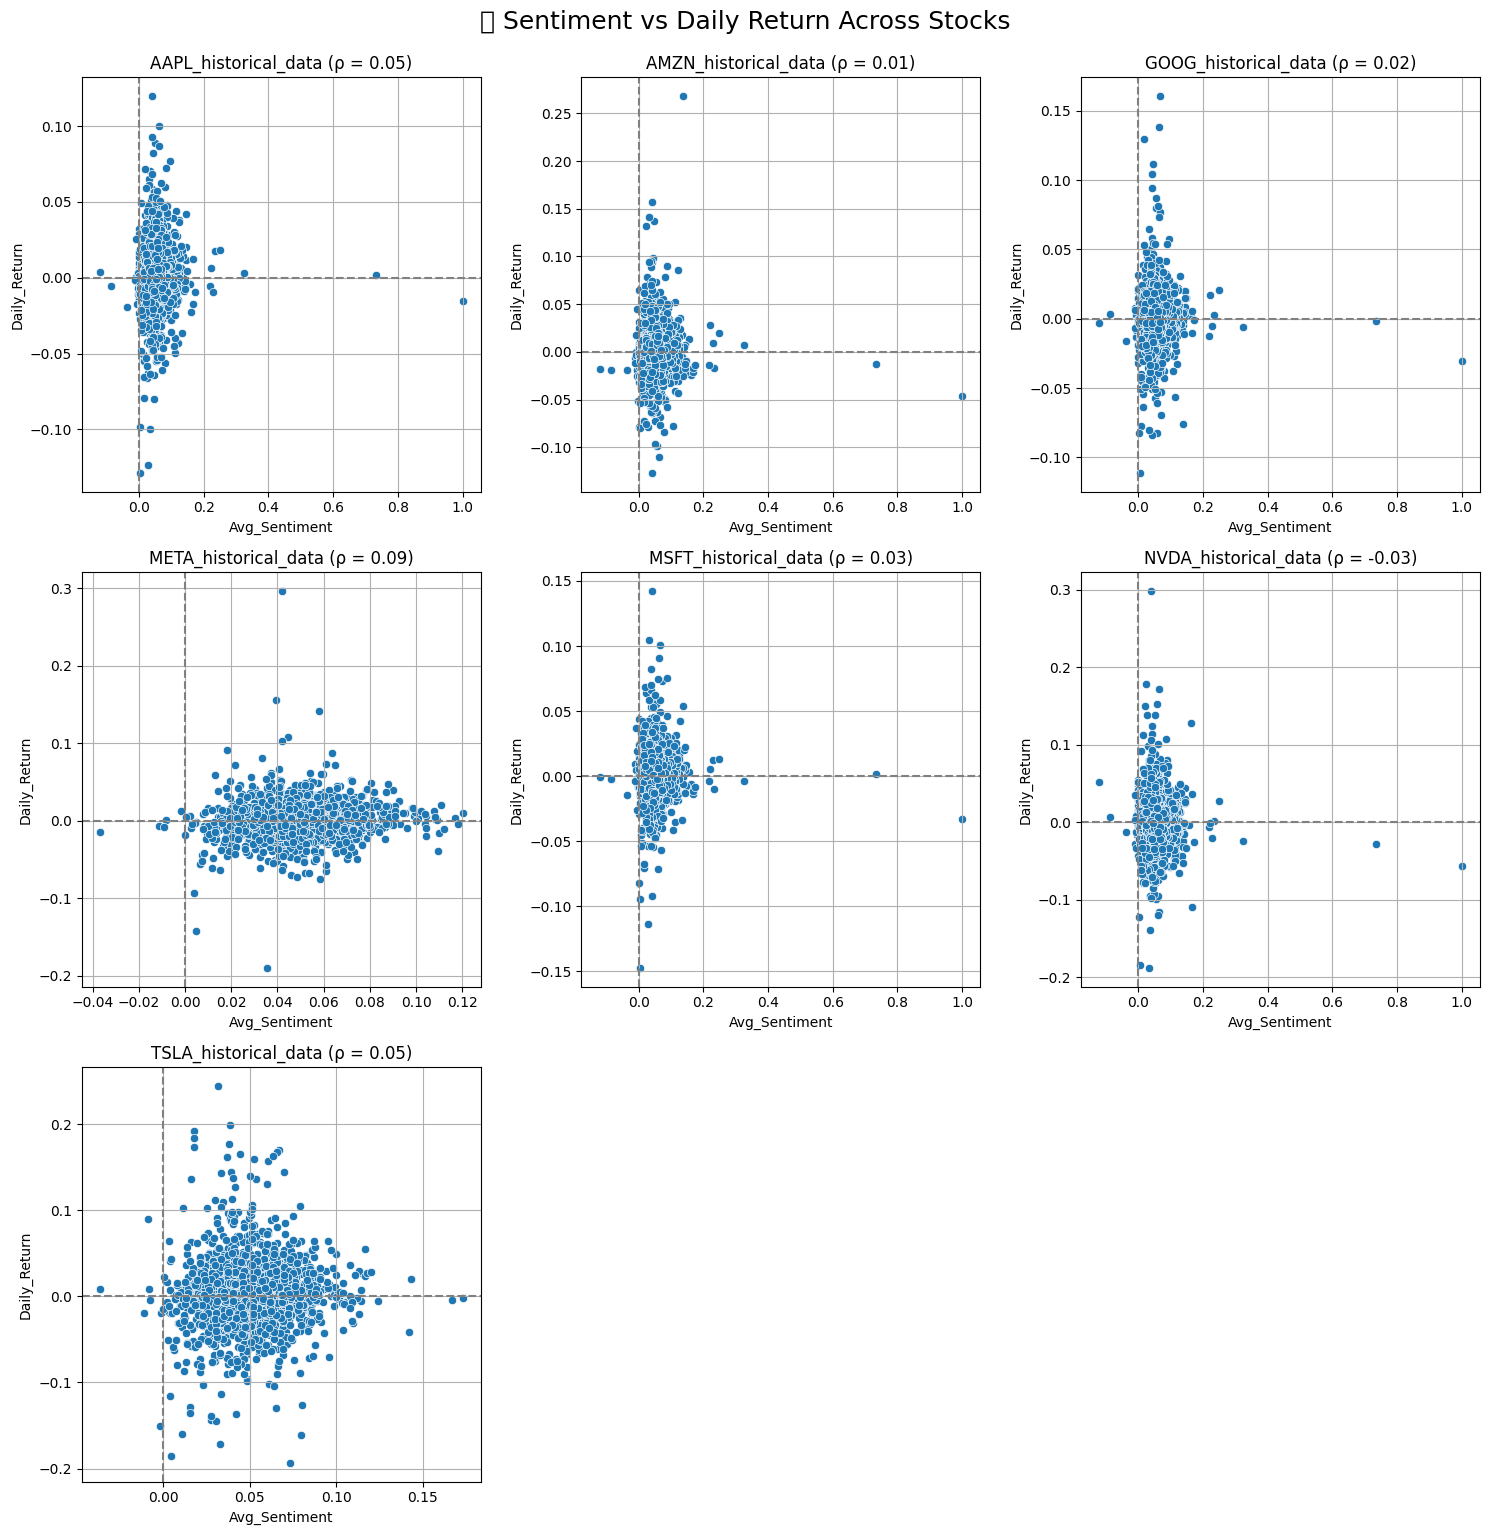

In [28]:
num_stocks = len(stock_returns)
cols = 3  # 3 columns for layout
rows = (num_stocks + cols - 1) // cols  # auto-calculate number of rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, (stock, result) in enumerate(stock_returns.items()):
    merged = result['Data']
    ax = axes[i]
    
    sns.scatterplot(data=merged, x='Avg_Sentiment', y='Daily_Return', ax=ax)
    ax.set_title(f'{stock} (ρ = {result["Correlation"]:.2f})')
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.grid(True)

# Turn off unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("📈 Sentiment vs Daily Return Across Stocks", fontsize=18, y=1.02)
plt.savefig("sentiment_vs_return_all_stocks.png", bbox_inches='tight')
plt.show()